In [25]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import urllib.request
import numpy as np
import os

In [26]:
# download Wisconsin COVID data from Wisconsin DHS database and save it to data_files folder
url = 'https://opendata.arcgis.com/datasets/b913e9591eae4912b33dc5b4e88646c5_10.csv'
cwd = os.getcwd()

if os.path.exists(cwd + '//data_files') == False:
    os.mkdir(cwd + '//data_files')
    urllib.request.urlretrieve(url, cwd + '//data_files//covid.csv')
else:
    urllib.request.urlretrieve(url, cwd + '//data_files//covid.csv')

# State-wide Data

In [27]:
pd.options.display.max_columns = None
wisc = pd.read_csv('data_files//covid.csv', parse_dates=True)
wisc = wisc.iloc[:, :-1]
wisc_counties_keep = ['LoadDttm', 'GEOID', 'GEO', 'NAME', 'NEGATIVE', 'POSITIVE', 'DEATHS']
wisc_counties = wisc[wisc['GEO']=='County']
wisc_counties = wisc_counties[wisc_counties_keep]
wisc_counties[['LoadDttm', 'temp']] = wisc_counties['LoadDttm'].str.split(expand=True)
wisc_counties = wisc_counties.drop('temp', axis=1).rename(columns={'LoadDttm':'Date'})
wisc_counties['Date'] = pd.to_datetime(wisc_counties['Date'])
wisc_counties.columns = [i.title() for i in wisc_counties.columns]
wisc_counties = wisc_counties.set_index(['Name', 'Date']).sort_index()

wisc_state = wisc[wisc['GEO']=='State']
wisc_state[['LoadDttm', 'temp']] = wisc_state['LoadDttm'].str.split(expand=True)
wisc_state = wisc_state.drop(['temp', 'OBJECTID', 'GEO', 'NAME', 'GEOID'], axis=1).rename(columns={'LoadDttm':'Date'})
wisc_state.columns = [i.title() for i in wisc_state.columns]
wisc_state['Date'] = pd.to_datetime(wisc_state['Date'])
wisc_state = wisc_state.set_index('Date')

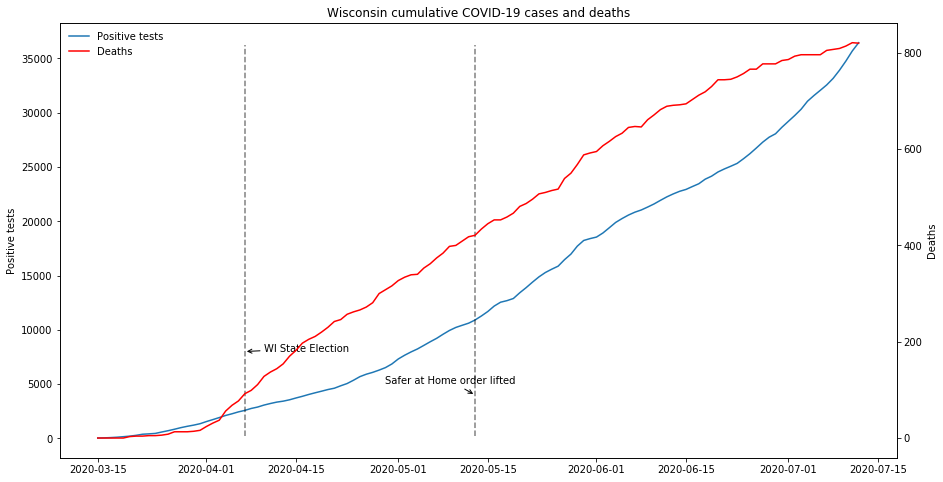

In [28]:
fig, ax = plt.subplots(figsize=[15,8])

ln1 = ax.plot(wisc_state.index, wisc_state['Positive'], label='Positive tests')
ax.axvline(x='2020/04/07', ymin=0.05, ymax=0.95,ls='--', c='black', alpha=0.5)
ax.axvline(x='2020/05/13', ymin=0.05, ymax=0.95, ls='--', c='black', alpha=0.5)
ax.set_ylabel('Positive tests')
ax.set_title('Wisconsin cumulative COVID-19 cases and deaths')
plt.annotate('WI State Election', ['2020-04-07', 8000], xytext=['2020-04-10', 8000], arrowprops=dict(arrowstyle='->'))
plt.annotate('Safer at Home order lifted', ['2020-05-13', 4000], xytext=['2020-04-29', 5000], arrowprops=dict(arrowstyle='->'))

ax2 = ax.twinx()

ln2 = ax2.plot(wisc_state.index, wisc_state['Deaths'], c='red', label='Deaths')
ax2.set_ylabel('Deaths')

lns = ln1+ln2
labels = [i.get_label() for i in lns]
ax.legend(lns, labels, frameon=False)

plt.show()

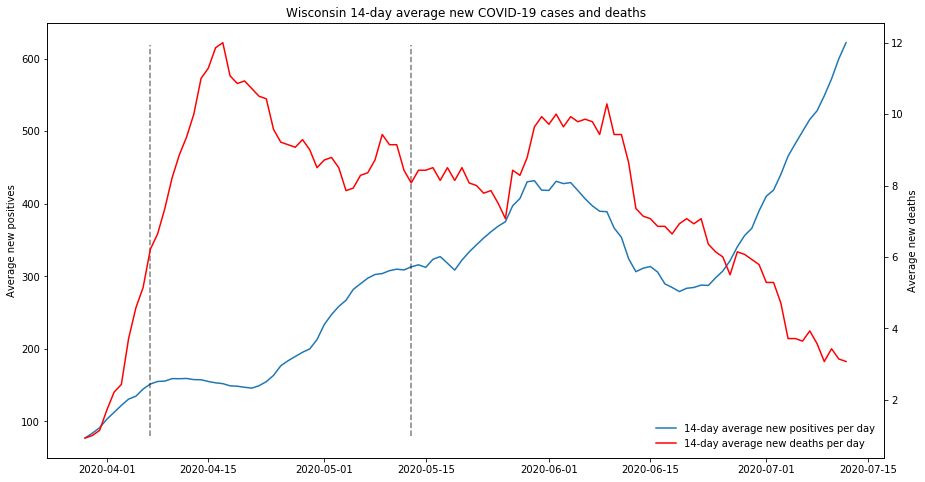

In [29]:
fig, ax = plt.subplots(figsize=[15,8])

ln1 = ax.plot(wisc_state.index, wisc_state['Pos_New'].rolling(14).mean(), 
        label='14-day average new positives per day')

ax.set_ylabel('Average new positives')
ax.set_title('Wisconsin 14-day average new COVID-19 cases and deaths')
ax.axvline(x='2020/04/07', ymin=0.05, ymax=0.95,ls='--', c='black', alpha=0.5)
ax.axvline(x='2020/05/13', ymin=0.05, ymax=0.95, ls='--', c='black', alpha=0.5)

ax2 = ax.twinx()
ln2 = ax2.plot(wisc_state.index, wisc_state['Dth_New'].rolling(14).mean(), color='red', 
         label='14-day average new deaths per day')

ax2.set_ylabel('Average new deaths')

lns = ln1+ln2
labels = [i.get_label() for i in lns]
ax.legend(lns, labels, frameon=False)

plt.show()

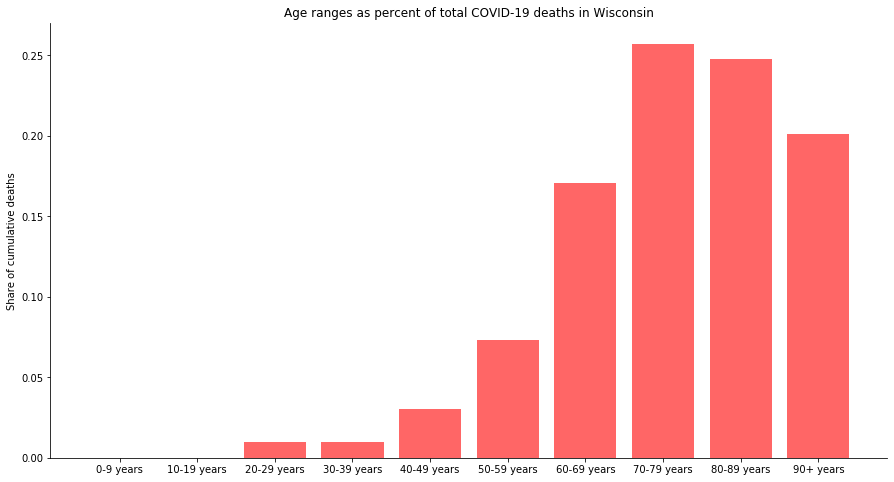

In [30]:
death_keep = ['Dths_0_9', 'Dths_10_19', 'Dths_20_29', 'Dths_30_39',
              'Dths_40_49', 'Dths_50_59', 'Dths_60_69', 'Dths_70_79',
              'Dths_80_89', 'Dths_90']

wisc_deaths = wisc_state[death_keep][-1:].transpose()
wisc_deaths.columns = ['Deaths']
wisc_deaths['Percentage'] = wisc_deaths['Deaths'] / sum(wisc_deaths['Deaths'])
wisc_deaths.index = ['0-9 years', '10-19 years', '20-29 years', '30-39 years',
                     '40-49 years', '50-59 years', '60-69 years', '70-79 years',
                     '80-89 years', '90+ years']

fig, ax = plt.subplots(figsize=[15,8])

ax.bar(wisc_deaths.index, wisc_deaths['Percentage'], color='red', alpha=0.6)
ax.set_ylabel('Share of cumulative deaths')
ax.set_title('Age ranges as percent of total COVID-19 deaths in Wisconsin')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

As expected, risk of dying from COVID-19 increases as one grows older, peaking in the 70-79 year range. I would hypothesize that people in the 80-89 and 90+ range actually have a higher risk of dying, but that there are simply significantly more people in the 70-79 range which counteracts the increased risk.

In [31]:
wisc_testing = wisc_state[['Pos_New','Neg_New', 'Test_New', 'Dth_New']]

# For some reason the value for 3-30 was entered as a negative. This function goes through the entire df and converts
# negative values to positive

def negative_cleanup(value):
    if value < 0:
        return abs(value)
    else:
        return value

wisc_testing = wisc_testing.applymap(lambda x: negative_cleanup(x))
wisc_testing['Pct_Pos'] = round((wisc_testing['Pos_New'] / wisc_testing['Test_New']), 3)
wisc_testing['Pct_Pos_14'] = wisc_testing['Pct_Pos'].rolling(14).mean()
wisc_testing_w = wisc_testing.resample('w').mean()
wisc_testing_w_sum = wisc_testing.resample('w').sum()

wisc_testing

,Pos_New,Neg_New,Test_New,Dth_New,Pct_Pos,Pct_Pos_14
Date,,,,,,
2020-03-15,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-16,15.0,191.0,206.0,0.0,0.073,NaN
2020-03-17,25.0,534.0,559.0,0.0,0.045,NaN
2020-03-18,34.0,539.0,573.0,0.0,0.059,NaN
2020-03-19,49.0,615.0,664.0,0.0,0.074,NaN
...,...,...,...,...,...,...
2020-07-08,598.0,10138.0,10736.0,2.0,0.056,0.062071
2020-07-09,754.0,12404.0,13158.0,2.0,0.057,0.063214
2020-07-10,845.0,11857.0,12702.0,5.0,0.067,0.063929


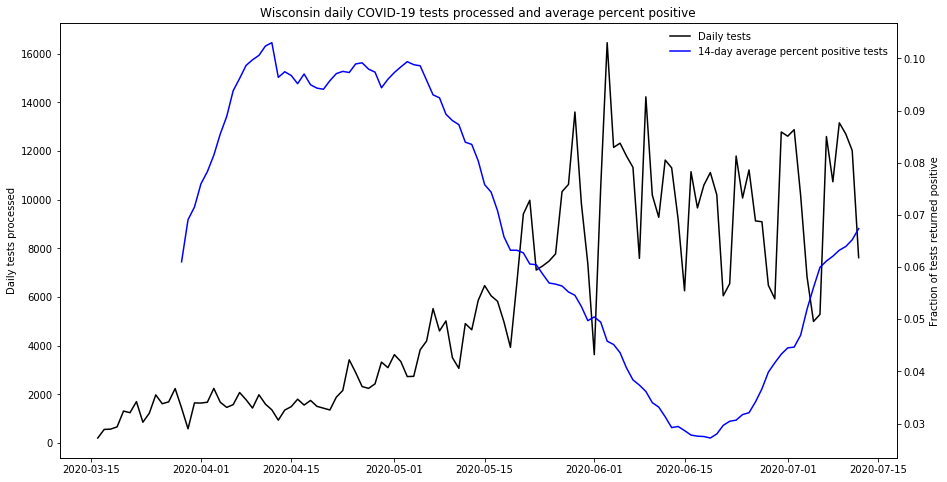

In [32]:
fig, ax = plt.subplots(figsize=[15,8])

ln1 = ax.plot(wisc_testing.index, wisc_testing['Test_New'], label='Daily tests', c='black')
ax.set_ylabel('Daily tests processed')
ax.set_title('Wisconsin daily COVID-19 tests processed and average percent positive')

ax2 = ax.twinx()
ln2 = ax2.plot(wisc_testing.index, wisc_testing['Pct_Pos_14'], label='14-day average percent positive tests', c='blue')
ax2.set_ylabel('Fraction of tests returned positive')

lns = ln1+ln2
labels = [i.get_label() for i in lns]
ax.legend(lns, labels, frameon=False)

plt.show()

At the beginning of the pandemic, testing supplies were still quite limited and only the sickest and most at-risk individuals were able to receive tests. I believe that this is why we saw such high levels of positivity at the beginning of the outbreak. Up until the Wisconsin Supreme Court lifted the stay-at-home order in May 2020, it is likely that infection rates stayed relatively constant or even decreased as most continued to adhere to social distancing. For this reason, Wisconsin's increase in testing capacity, seen on the graph exhibiting a noticeable increase in May 2020, served to drive the percent positive rate down as more were being tested with similar rates of COVID-19 transmission. The concerning point in the graph begins at the right-most trough of the percent positivity plot. Since this trough, Wisconsin has experienced a ~4% increase in average percent positivity which has not been accompanied by a drastic change in overall testing capacity. This would seem to imply that Wisconsin is currently experiencing increased rates of COVID-19 transmission as compared to previous months.

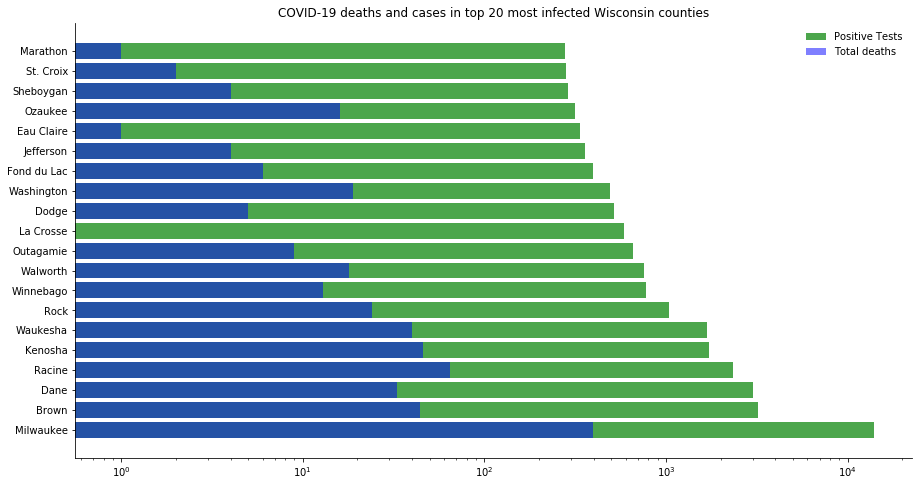

In [33]:
counties = []
counties = pd.DataFrame(counties)
counties['Name'] = np.nan
init = 0

for i in wisc_counties.index.get_level_values(0).unique():
    counties = counties.append(wisc_counties.xs(i, level=0)[-1:], sort=True)
    counties.iloc[init, 3] = i
    init += 1

counties = counties.reset_index().set_index('Name')
counties = counties.drop(['Geo', 'Geoid', 'index'], axis=1)
counties['Total'] = counties['Negative'] + counties['Positive']

counties_ordered = counties.sort_values('Positive', ascending=False)
counties_ordered = counties_ordered[:20]

fig, ax = plt.subplots(figsize=[15,8])

ax.barh(counties_ordered.index, counties_ordered['Positive'], color='green', alpha=0.7, log=True, label='Positive Tests')
ax.barh(counties_ordered.index, counties_ordered['Deaths'], color='blue', alpha=0.5, label='Total deaths')
ax.legend(frameon=False)
ax.set_title('COVID-19 deaths and cases in top 20 most infected Wisconsin counties')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Racial Disparities

In [34]:
# Data on Hispanic populations is recorded through a separate survey question, so it would be hard to use it properly in
# this dataset without more information. For this reason, I am not including Hispanic populations in this data.
race_keep = ['Pos_Aian', 'Pos_Asn', 'Pos_Blk', 'Pos_Wht', 'Pos_Mltoth', 'Pos_Unk',
             'Dth_Aian', 'Dth_Asn', 'Dth_Blk', 'Dth_Wht', 'Dth_Mltoth', 'Dth_Unk']
race_names = ['American Indian or Alaskan native', 'Asian', 'Black', 'White',
              'Multiracial or other', 'Unknown' ]

wisc_race = wisc_state[race_keep]
wisc_race = wisc_race[-1:].transpose()
wisc_race.columns = ['Value']
wisc_race_pos = wisc_race[:6]
wisc_race_dth = wisc_race[6:]
wisc_race_pos['Share'] = wisc_race_pos['Value'] / sum(wisc_race_pos['Value'])
wisc_race_dth['Share'] = wisc_race_dth['Value'] / sum(wisc_race_dth['Value'])

wisc_race_dth.index = race_names
wisc_race_dth = wisc_race_dth.rename(columns={'Value':'Deaths'})

wisc_race_pos.index = race_names
wisc_race_pos = wisc_race_pos.rename(columns={'Value':'Positive tests'})

C:\Users\Owner\Anaconda3_2\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\Owner\Anaconda3_2\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


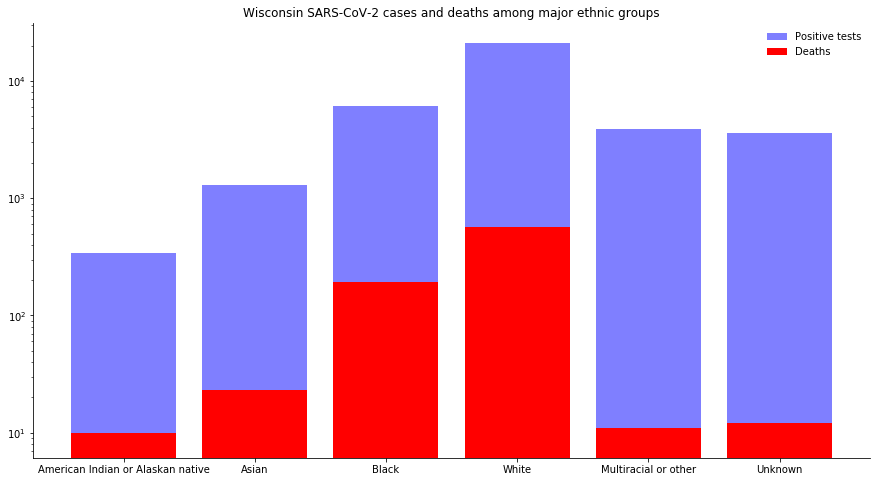

In [35]:
fig, ax = plt.subplots(figsize=[15,8])

ax.bar(wisc_race_pos.index, wisc_race_pos['Positive tests'], color='blue', log=True, alpha=0.5, label='Positive tests')
ax.bar(wisc_race_dth.index, wisc_race_dth['Deaths'], color='red', label='Deaths')

ax.set_title('Wisconsin COVID-19 cases and deaths among major ethnic groups')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon=False)

In [36]:
# I found some data on Wisconsin's racial demographics from the US Census. I would like to see which groups are being
# disproportionately affected by the coronavirus.

demo = pd.read_csv('data_files//demographics.csv',skipfooter=21, usecols=['Fact','Wisconsin'], thousands=',', engine='python')

def percent_strip(x):
    return float(x.strip('%'))/100

demo = demo[11:19].set_index('Fact')
demo['Wisconsin'] = demo['Wisconsin'].map(percent_strip)
demo.index = ['White', 'Black', 'American Indian or Alaskan native', 'Asian', 'Hawaiian or Pacific Islander', 
              'Multiracial or other', 'Hispanic or Latino', 'White, not Hispanic or Latino']
demo = demo.rename(columns={'Wisconsin':'Share of population'}).sort_index()

# Dropping the rows I don't have data for in both data frames
race_differences = demo.drop(['Hawaiian or Pacific Islander', 'Hispanic or Latino', 'White, not Hispanic or Latino'], axis=0)

# Here, I'm using the assumption that all ethnic groups are equally affected by the virus to determine how many cases 
# you would expect each group to have at this point in time
race_differences['Expected cases'] = race_differences['Share of population'] * sum(wisc_race_pos['Positive tests'])
race_differences['Actual cases'] = wisc_race_pos.drop('Unknown', axis=0)['Positive tests']
race_differences['Case difference'] = race_differences['Actual cases'] - race_differences['Expected cases']

# Same process, only for deaths.
race_differences['Expected deaths'] = race_differences['Share of population'] * sum(wisc_race_dth['Deaths'])
race_differences['Actual deaths'] = wisc_race_dth.drop('Unknown', axis=0)['Deaths']
race_differences['Death difference'] = race_differences['Actual deaths'] - race_differences['Expected deaths']

race_differences

,Share of population,Expected cases,Actual cases,Case difference,Expected deaths,Actual deaths,Death difference
American Indian or Alaskan native,0.012,437.376,338.0,-99.376,9.84,10.0,0.16
Asian,0.030,1093.440,1285.0,191.560,24.60,23.0,-1.60
Black,0.067,2442.016,6076.0,3633.984,54.94,192.0,137.06
Multiracial or other,0.020,728.960,3901.0,3172.040,16.40,11.0,-5.40
White,0.871,31746.208,21236.0,-10510.208,714.22,572.0,-142.22


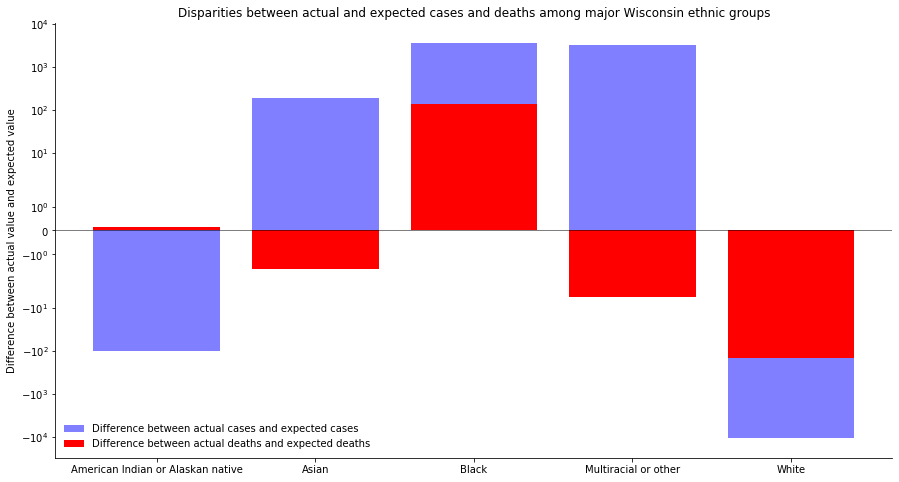

In [37]:
fig, ax = plt.subplots(figsize=[15,8])


ax.bar(race_differences.index, race_differences['Case difference'], color='blue', alpha=0.5, 
       label='Difference between actual cases and expected cases')
ax.bar(race_differences.index, race_differences['Death difference'], color='red', 
       label='Difference between actual deaths and expected deaths')

ax.axhline(color='black', linewidth=0.5)
ax.set_ylabel('Difference between actual value and expected value')
ax.set_title('Disparities between actual and expected cases and deaths among major Wisconsin ethnic groups')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon=False, loc=3)

plt.gca().set_yscale('symlog')

To create this graph, I calculated the number of cases and deaths you would expect for each ethnic group listed based purely on their share of Wisconsin's population. In doing this, I controlled for extraneous variables which could contribute to a given ethnic group being affected by a lesser or greater degree. I then calculated the difference between the "expected" value and actual value for each ethnic group and plotted the data in the above graph. From the graph, we can see that white populations are being affected by the coronavirus a disproportionately low amount compared to other ethnic groups. They are experiencing over 10,000 fewer cases and 142 fewer deaths than would be expected of a population of their size. Conversely, the black population in Wisconsin is suffering significantly more than would be expected, experiencing 3593 more cases and 137 more deaths. 

# Dane County Data

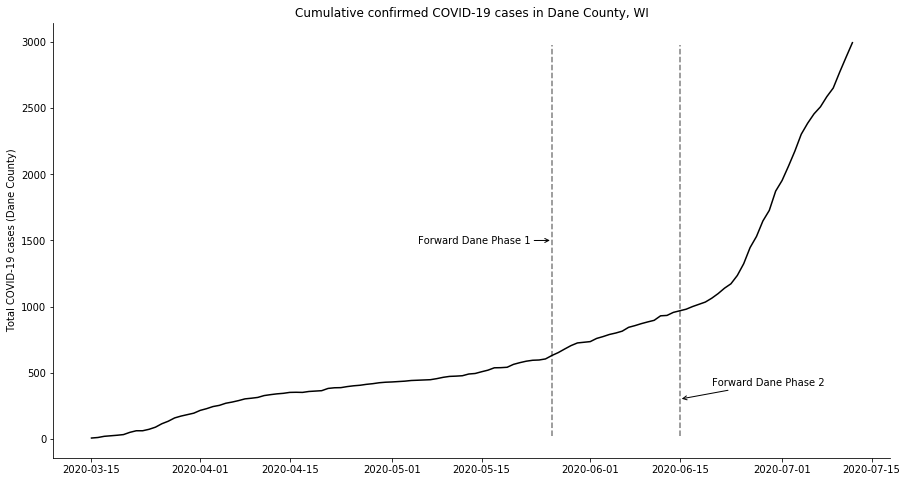

In [38]:
dane = wisc_counties.xs('Dane')
dane = dane.fillna(0)
dane['New_positives'] = dane['Positive'].diff()
dane['New_negatives'] = dane['Negative'].diff()
dane['New_tests'] = dane['New_positives'] + dane['New_negatives']

fig, ax = plt.subplots(figsize=[15,8])

ax.plot(dane.index, dane['Positive'], label='Total positive cases', c='black')
ax.set_ylabel('Total COVID-19 cases (Dane County)')
ax.set_title('Cumulative confirmed COVID-19 cases in Dane County, WI')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axvline(x='2020/05/26', ymin=0.05, ymax=0.95,ls='--', c='black', alpha=0.5)
ax.axvline(x='2020/06/15', ymin=0.05, ymax=0.95,ls='--', c='black', alpha=0.5)
plt.annotate('Forward Dane Phase 1', ['2020-05-26', 1500], xytext=['2020-05-05', 1475], arrowprops=dict(arrowstyle='->'))
plt.annotate('Forward Dane Phase 2', ['2020-06-15', 300], xytext=['2020-06-20', 400], arrowprops=dict(arrowstyle='->'))

plt.show()

"Forward Dane" is the Dane County-specific COVID-19 reopening plan. Phase 1 allowed for some non-essential businesses to reopen but notably did not yet allow for bars and restaurants to reopen for dine-in seating. Phase 2, however, allowed bars and restaurants to reopen for dine-in seating with reduced capacity. The county did not see a noticeable increase in COVID-19 cases following the implementation of Phase 1, but within a few weeks of Phase 2's implementation the county experienced a massive increase in the rate of new COVID-19 cases. It is possible that the newly loosened restrictions on businesses within the county contributed to the sudden increase in new cases.

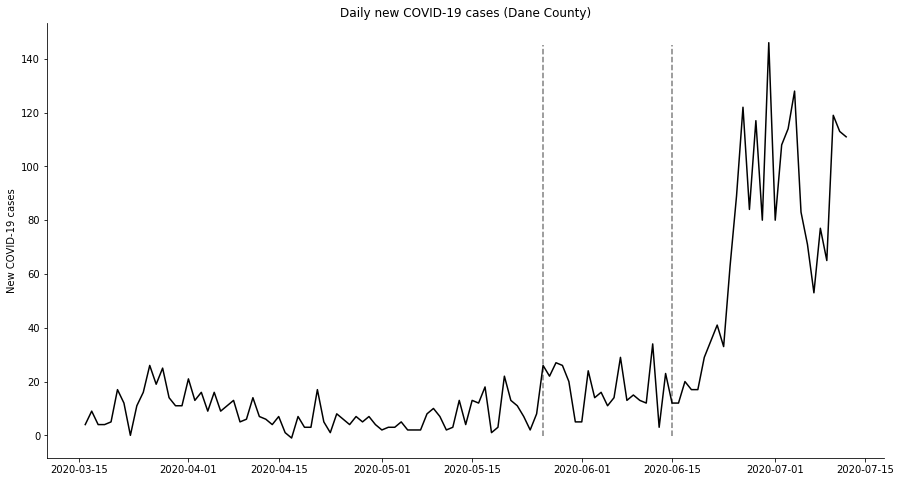

In [39]:
fig, ax = plt.subplots(figsize=[15,8])

ax.plot(dane.index, dane['New_positives'], c='black')
ax.set_ylabel('New COVID-19 cases')
ax.set_title('Daily new COVID-19 cases (Dane County)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.axvline(x='2020/05/26', ymin=0.05, ymax=0.95,ls='--', c='black', alpha=0.5)
ax.axvline(x='2020/06/15', ymin=0.05, ymax=0.95,ls='--', c='black', alpha=0.5)

plt.show()